#### Importing necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import make_scorer,f1_score,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score,roc_curve
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import binarize, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\INISH\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


#### Creating functions which are being used repeateadly

In [2]:
# define a function to print accuracy metrics
def print_accuracy_metrics(Input,Output):
  print("Recall:", recall_score(Input, Output))
  print("Log Loss:", log_loss(Input, Output))
  print("Precision:", precision_score(Input, Output))
  print("Accurcay:", accuracy_score(Input, Output))
  print("AUC: ", roc_auc_score(Input, Output))
  print("F1 Score:", f1_score(Input, Output))
  confusion_matrix_value = confusion_matrix(Input,Output)
  print('Confusion matrix:\n', confusion_matrix_value)
  class_names=[0,1] # name  of classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # create heatmap
  sns.heatmap(pd.DataFrame( confusion_matrix_value), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  

In [3]:
# defined a function to print cross validation score
scoring = {'recall' : make_scorer(recall_score)}
def cross_validation_metrics(log_reg, X, y):
 log_reg_score = cross_val_score(log_reg, X,y,cv=5,scoring='recall')
 print('Logistic Regression Cross Validation Score(Recall): ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

In [4]:
# function for plotting feature importance
def feature_importance(model, X):
  importances = model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in model.estimators_],
               axis=0)
  indices = np.argsort(importances)[::-1]

  # Print the feature ranking
  print("Feature ranking:")

  for f in range(X.shape[1]):
      print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

  # Plot the feature importances of the forest
  plt.figure()
  plt.title("Feature importances")
  plt.bar(range(X.shape[1]), importances[indices],
          color="r", yerr=std[indices], align="center")
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()

In [5]:
# function to draw ROC curve
def plot_auc_curve(model,):
  auc = roc_auc_score(y, y_pred_prob)
  fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
  
  plt.plot(fpr, tpr)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.title('ROC Curve\n AUC={auc}'.format(auc = auc))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid(True)

In [7]:
### Reading data as a pandas dataframe
data = pd.read_csv('creditcard.csv')

#### Data Exploration

In [8]:
#### Exploring data set
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


#### Observations

In [10]:
data.shape

(284807, 31)

In [11]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [12]:
#### Checking for null values in dataset
data.isnull().sum().max()

0

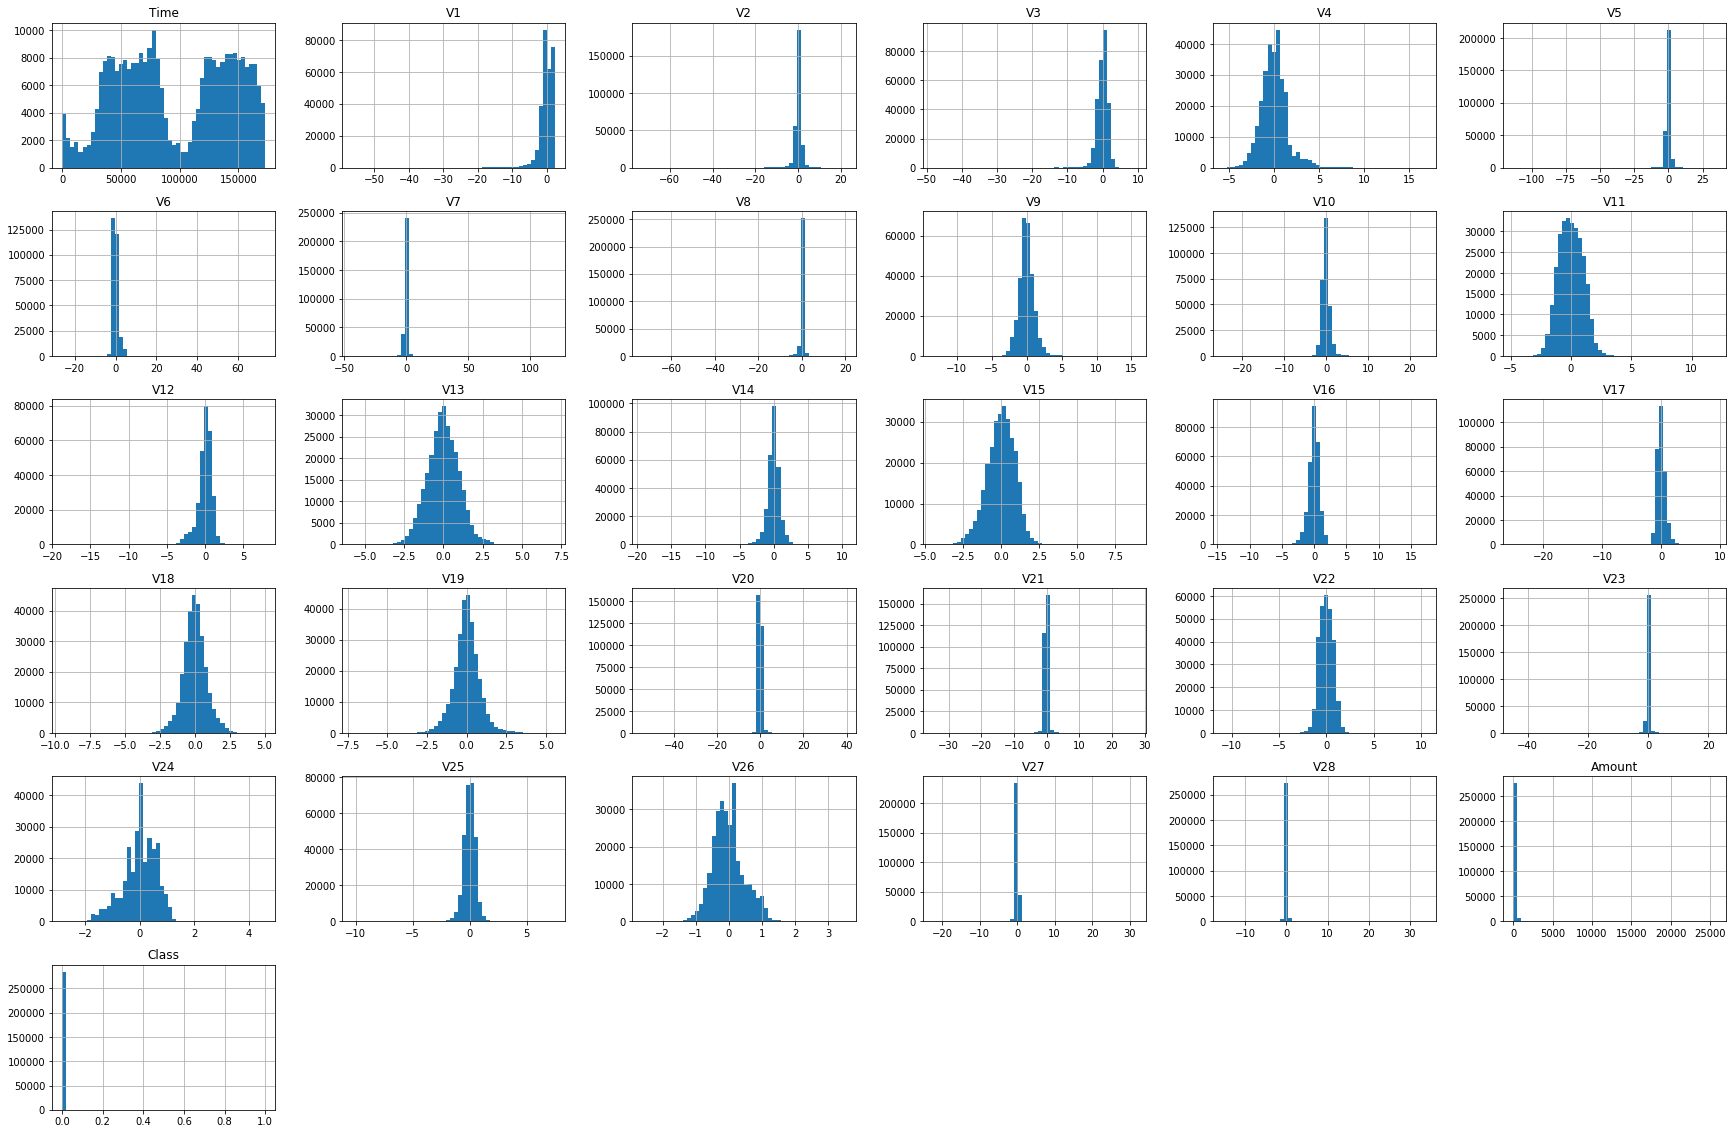

In [14]:
# Plot the histograms of each 
data.hist(bins=50, figsize=(30,20))
plt.show()

##### We can observe that all the features in dataset are scaled except amount and time.
##### So, in next step I am going to scale Amount column in dataset and delete time column.

In [8]:
data['normal_amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data = data.drop(['Amount','Time'], axis=1)
X = data.loc[:,data.columns != 'Class']
y = data.loc[:,data.columns == 'Class']

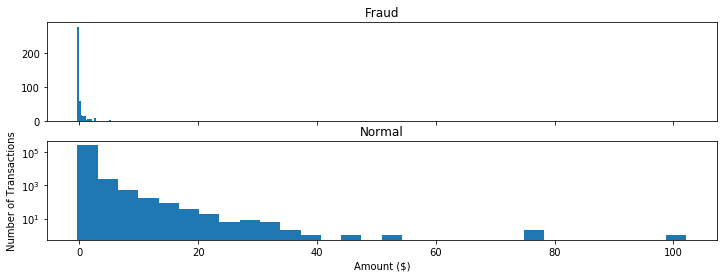

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 30

ax1.hist(data.normal_amount[data.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(data.normal_amount[data.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

##### We can observe from the above figure that the fraud transactions amount is very less.
##### In next step I am going to visualize number of fraud transactions and number of Non-fraud transactions.

Text(0, 0.5, 'Frequency')

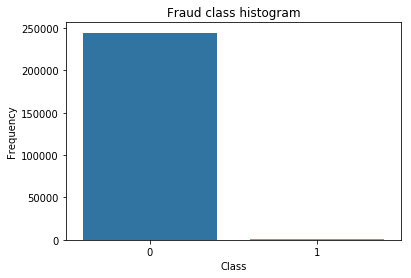

In [16]:
# Now lets check the class distributions
sns.countplot("Class",data=data)
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

##### As you can observe from the plot, we have so many 0 (non-fraud) compared to 1 (fraud). 
##### This kind of imbalance in the target variable is known as class imbalance.

In [17]:
# Showing ratio
print("Percentage of normal transactions: ", len(data[data.Class == 0])/len(data))
print("Percentage of fraud transactions: ", len(data[data.Class == 1])/len(data))
print("Total number of transactions in data: ", len(data))

Percentage of normal transactions:  0.9982761930827141
Percentage of fraud transactions:  0.0017238069172858619
Total number of transactions in data:  244807


##### Most of the transactions were Non-Fraud (99.83%) of the time,
##### while Fraud transactions occurs 0.17% of the time in the dataframe.

#### Splitting original dataset into test and train

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

### 1] Logistic regression on imbalanced dataset

In [19]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Logistic Regression Cross Validation Score(Recall):  60.16%
Recall: 0.6481481481481481
Log Loss: 0.021162677654140833
Precision: 0.9090909090909091
Accurcay: 0.9993872799313753
AUC:  0.8240263478860329
F1 Score: 0.7567567567567568
Confusion matrix:
 [[73328     7]
 [   38    70]]


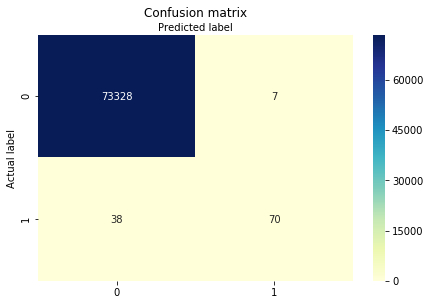

In [20]:
# Accuracy metrics for 
y_pred = lr.predict(X_test)
cross_validation_metrics(lr,X_train,y_train)
print_accuracy_metrics(y_test,y_pred)

##### Observatios
By observing the accuracy we can conclude that algorithm is performing extremely well . But it’s not true. As most of the labels 0, even random guess gives you 99% accuracy. So we need a better measure to understand the performance of the model. 

##### Recall
Recall is a measure which measures the ability of model to predict right for a given label. In our case, we want to test the model how accurately it can recall fraud cases as we are interested in that.
As you can observe from the results, the recall for 1.0 is only 0.6016 compared to 99% for 0. So our model is not doing a good job of recognising frauds. So this shows that how imbalanced data is effecting accuracy of model.

### 2]  Using Class Weight (Logistic regression)
Scikit-learn logistic regression has a option named class_weight when specified does class imbalance handling implicitly. So trying to predict using this technique

In [11]:
lr_balanced = LogisticRegression(class_weight = 'balanced')
lr_balanced.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Logistic Regression Cross Validation Score(Recall):  89.86%
Recall: 0.9115646258503401
Log Loss: 0.7882701074435376
Precision: 0.06470304200869145
Accurcay: 0.9771777676345634
AUC:  0.9444277359227315
F1 Score: 0.12082957619477007
Confusion matrix:
 [[83359  1937]
 [   13   134]]


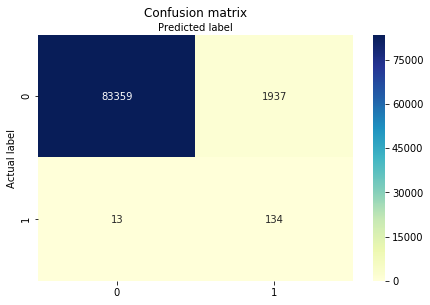

In [12]:
y_balanced_pred = lr_balanced.predict(X_test)
cross_validation_metrics(lr_balanced,X_train,y_train)
print_accuracy_metrics(y_test,y_balanced_pred)

In [23]:
y_balanced_pred_prob = lr_balanced.predict_proba(X_test)[:, 1]

In [24]:
print('Prob:', y_balanced_pred_prob[0:20])

Prob: [0.11795312 0.10853555 0.16233188 0.04109433 0.06952336 0.8054823
 0.33638875 0.01525269 0.01663033 0.45291477 0.03846819 0.02975751
 0.00137332 0.00313013 0.00775784 0.05660248 0.01766819 0.00898342
 0.09351198 0.05154421]


In [25]:
print('Prob:', y_balanced_pred[0:20])

Prob: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


##### Undersampling of the dataset
Undersampling is one of the techniques used for handling class imbalance.
In this technique, we under sample majority class to match the minority class.
So in our example, we take random sample of non-fraud class to match number of fraud samples. 
This makes sure that the training data has equal amount of fraud and non-fraud samples.

In [28]:
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

In [29]:
normal_indices = data[data.Class == 0].index

In [30]:
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

In [31]:
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

In [32]:
under_sample = data.iloc[under_sample_indices,:]

In [28]:
under_sample.shape

(844, 30)

So there are total 844 observations in our undersample dataframe.
##### Visualising Undersampled Data

Text(0, 0.5, 'Frequency')

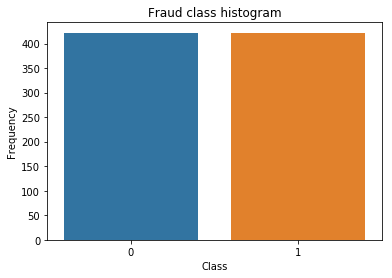

In [29]:
# Now lets check the class distributions
sns.countplot("Class",data=under_sample)
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

##### In the above plot, you can observe that classes are distributed evenly now.

If we try to correlate class and features on imbalanced dataset then it will be of no use because we will not see true correlations of features with result. While now I am going to see the features and their correlations w.r.t class on undersampled dataframe.

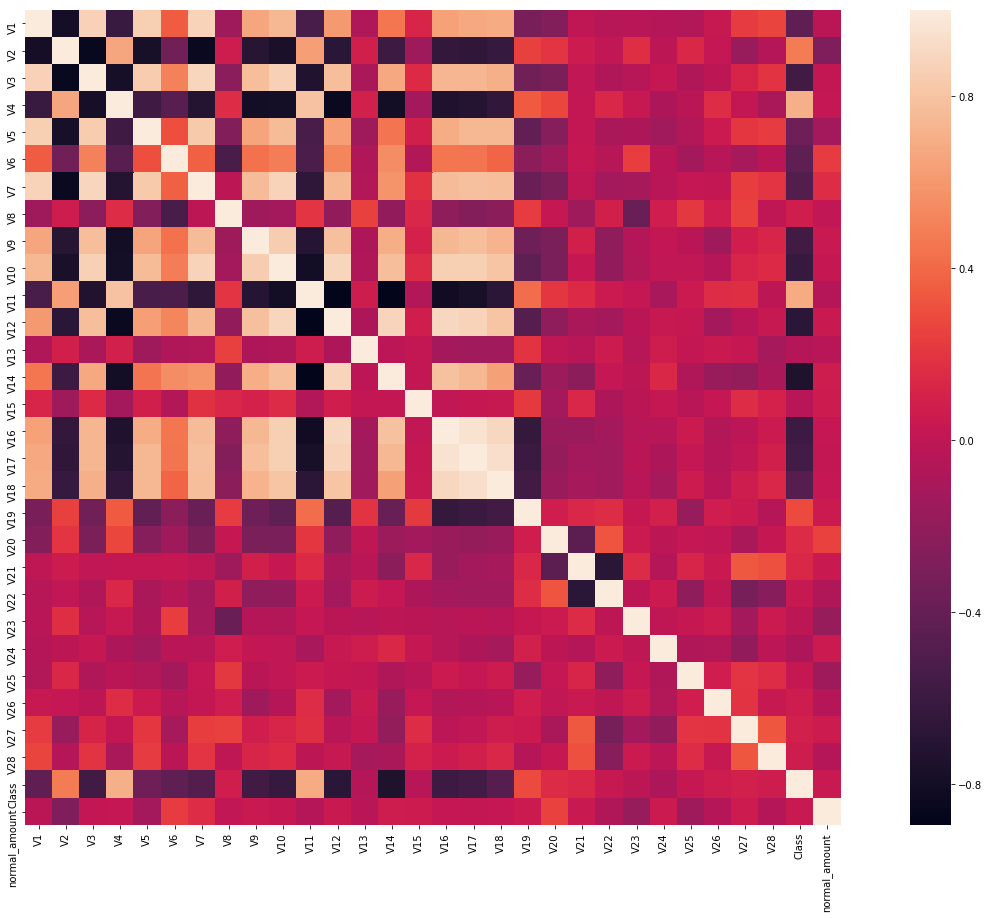

In [28]:
# correlation matrix
corrmat =under_sample.corr()
fig,ax= plt.subplots()
fig.set_size_inches(25,15)
sns.heatmap(corrmat,square=True)

In [47]:
rf = RandomForestClassifier(n_estimators=100, 
                            criterion='gini', 
                            max_features='sqrt',
                            n_jobs=-1)
rf.fit(X_under_train, y_under_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Feature ranking:
1. V14 (0.163468)
2. V10 (0.142475)
3. V4 (0.135820)
4. V17 (0.077558)
5. V3 (0.066908)
6. V12 (0.063024)
7. V11 (0.059748)
8. V7 (0.035103)
9. V2 (0.029975)
10. V16 (0.025015)
11. V18 (0.020058)
12. V8 (0.014964)
13. V6 (0.014854)
14. V5 (0.011935)
15. V23 (0.011827)
16. V9 (0.011814)
17. V19 (0.011713)
18. V13 (0.011508)
19. V1 (0.010258)
20. V27 (0.010227)
21. V20 (0.010050)
22. normal_amount (0.009788)
23. V21 (0.008971)
24. V22 (0.008304)
25. V15 (0.008091)
26. V28 (0.006979)
27. V26 (0.006722)
28. V25 (0.006679)
29. V24 (0.006168)


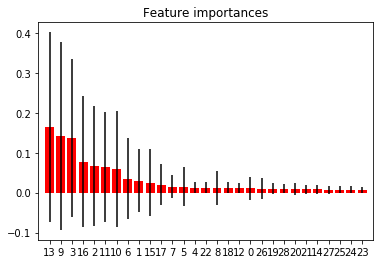

In [48]:
feature_importance(rf,X_under_train)

##### From the above heeatmap we can say that many of features are correlated but we are more interested in correlation of features with class. So I am going to list those features whose correlation coefficient w.r.t class is less than -0.6 or greater than 0.6

In [30]:
#negative correlations smaller than -0.5
corr = under_sample.corr()
corr = corr[['Class']]
corr[corr.Class < -0.6]

,Class
V10,-0.633606
V12,-0.677653
V14,-0.740321


In [31]:
#positive correlations greater than 0.5
corr[corr.Class > 0.6]

,Class
V4,0.698864
V11,0.688469
Class,1.000000


##### BoxPlots
We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions.

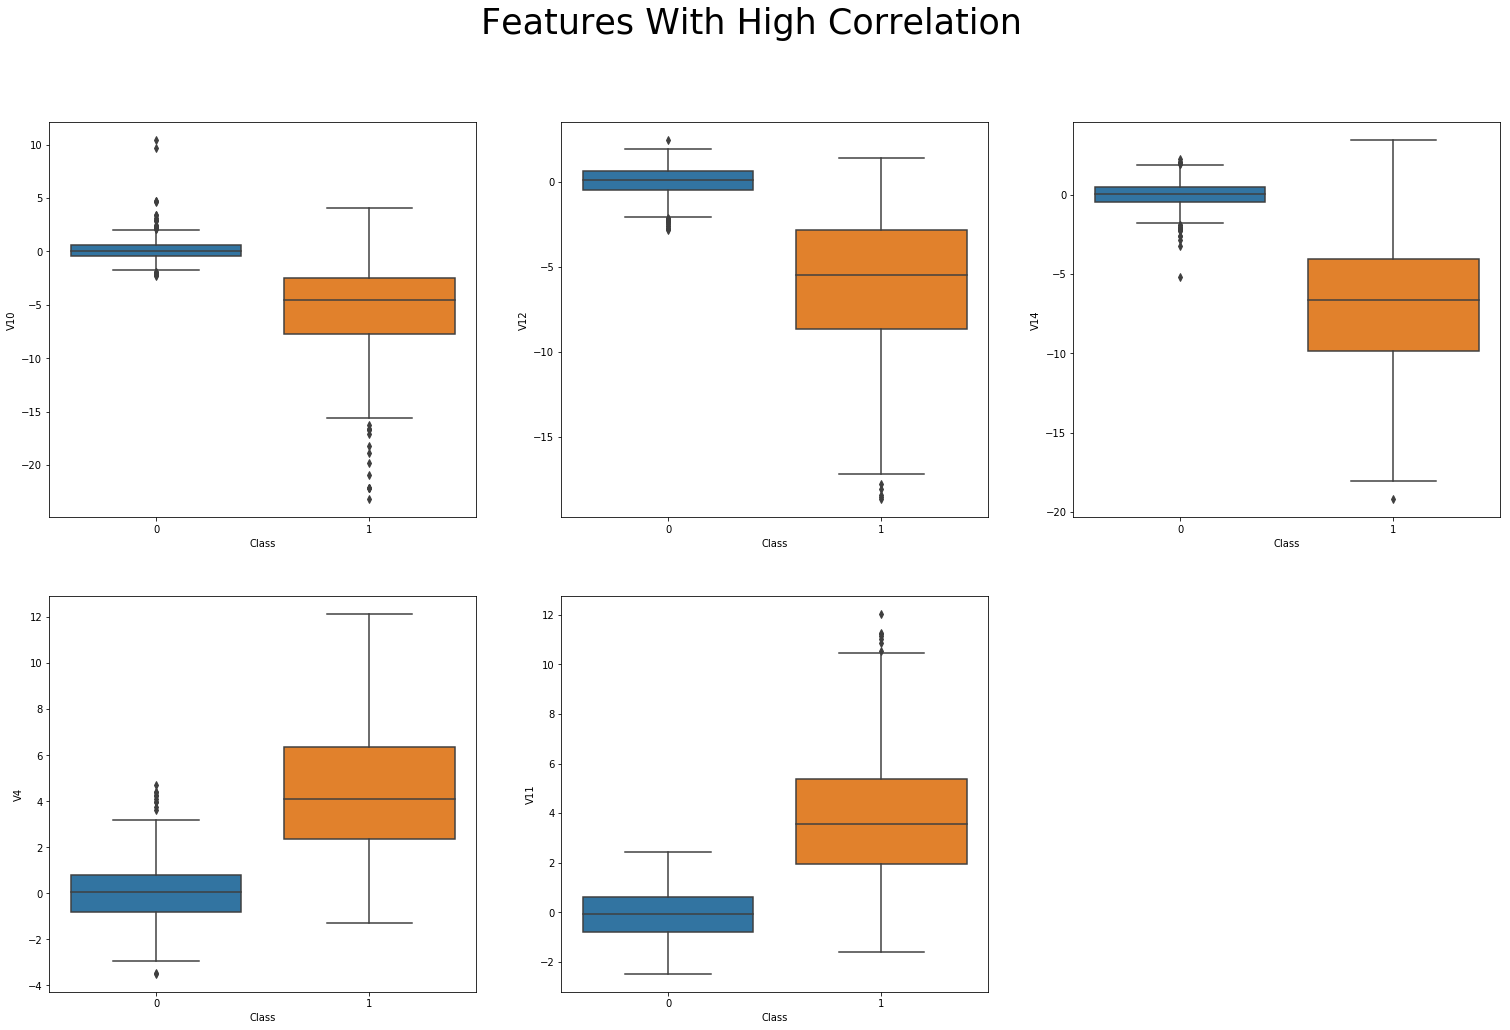

In [32]:
#visualizing the features with high correlation
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(26,16))
f.suptitle('Features With High Correlation', size=35)
sns.boxplot(x="Class", y="V10", data=under_sample, ax=axes[0,0])
sns.boxplot(x="Class", y="V12", data=under_sample, ax=axes[0,1])
sns.boxplot(x="Class", y="V14", data=under_sample, ax=axes[0,2])
sns.boxplot(x="Class", y="V4", data=under_sample, ax=axes[1,0])
sns.boxplot(x="Class", y="V11", data=under_sample, ax=axes[1,1])
f.delaxes(axes[1,2])

Box plots provide us with a good intuition of whether we need to worry about outliers as all transactions outside of 1.5 times the IQR (Inter-Quartile Range) are usually considered to be outliers. However, removing all transactions outside of 1.5 times the IQR would dramatically decrease  training data size, which is not very large, to begin with. Thus, I decided to only focus on extreme outliers outside of 2.5 times the IQR.

In [33]:
under_sample.shape

(844, 30)

###### Removing extreme outliers

In [18]:
v14_fraud = under_sample['V14'].loc[under_sample['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
v14_iqr = q75 - q25
v14_cut_off = v14_iqr * 2.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
under_sample= under_sample.drop(under_sample[(under_sample['V14'] > v14_upper) | (under_sample['V14'] < v14_lower)].index)


In [19]:
v12_fraud = under_sample['V12'].loc[under_sample['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25
v12_cut_off = v12_iqr * 2.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
under_sample= under_sample.drop(under_sample[(under_sample['V12'] > v12_upper) | (under_sample['V12'] < v12_lower)].index)


In [20]:
v10_fraud = under_sample['V10'].loc[under_sample['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25
v10_cut_off = v10_iqr * 2.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
under_sample= under_sample.drop(under_sample[(under_sample['V10'] > v10_upper) | (under_sample['V10'] < v10_lower)].index)


In [21]:
v4_fraud = under_sample['V4'].loc[under_sample['Class'] == 1].values
q25, q75 = np.percentile(v4_fraud, 25), np.percentile(v4_fraud, 75)
v4_iqr = q75 - q25
v4_cut_off = v4_iqr * 2.5
v4_lower, v4_upper = q25 - v4_cut_off, q75 + v4_cut_off
under_sample= under_sample.drop(under_sample[(under_sample['V4'] > v4_upper) | (under_sample['V4'] < v4_lower)].index)

In [22]:
v11_fraud = under_sample['V11'].loc[under_sample['Class'] == 1].values
q25, q75 = np.percentile(v11_fraud, 25), np.percentile(v11_fraud, 75)
v11_iqr = q75 - q25
v11_cut_off = v11_iqr * 2.5
v11_lower, v11_upper = q25 - v11_cut_off, q75 + v11_cut_off
under_sample= under_sample.drop(under_sample[(under_sample['V11'] > v11_upper) | (under_sample['V11'] < v11_lower)].index)

In [23]:
under_sample.shape

(976, 30)

##### After removing outliers our under sample dataframe is reduced to 

I have tried to run this notebook without removing outliers and after removing outliers but I got better result before removing outliers.Before even thinking of removing outliers there should be enough evidence that these observations are actual outliers Before removing outliers. It should be done by in depth statistical analysis to make sure that these observations are actual outliers because different ML methods used for detecting fraud, are based on anomaly detection and they treat such extreme outliers as frauds. So, by deleting it we delete the most important observations, that have higher probability of being frauds

##### Splitting under sampled dataframe

In [33]:
X_under = under_sample.loc[:,under_sample.columns != 'Class']
y_under = under_sample.loc[:,under_sample.columns == 'Class']
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under,y_under,test_size = 0.3, random_state = 0)

### 3] Logistic regression with C=0.01

In [34]:
lr_under_C1 = LogisticRegression(C=0.01,penalty = 'l1')
lr_under_C1.fit(X_under_train,y_under_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Logistic Regression Cross Validation Score(Recall):  96.23%
Recall: 0.9115646258503401
Log Loss: 3.5007281778367507
Precision: 0.01526022093155677
Accurcay: 0.8986458808796508
AUC:  0.9050941212162975
F1 Score: 0.030017921146953407
Confusion matrix:
 [[76649  8647]
 [   13   134]]


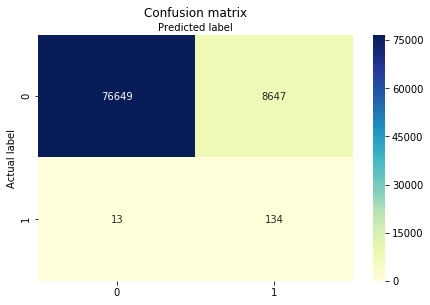

In [35]:
# Prediction on original dataframe
y_pred_full_model1 = lr_under_C1.predict(X_test)
cross_validation_metrics(lr_under_C1,X_under_train,y_under_train)
print_accuracy_metrics(y_test,y_pred_full_model1)

### 4] Logistic regression with C=0.1

In [36]:
lr_under_C2 = LogisticRegression(C=0.1,penalty = 'l1')
lr_under_C2.fit(X_under_train,y_under_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Logistic Regression Cross Validation Score(Recall):  88.99%
Recall: 0.9115646258503401
Log Loss: 0.6209142741882784
Precision: 0.08086904043452021
Accurcay: 0.9820231031213792
AUC:  0.9468545789165413
F1 Score: 0.14855875831485585
Confusion matrix:
 [[83773  1523]
 [   13   134]]


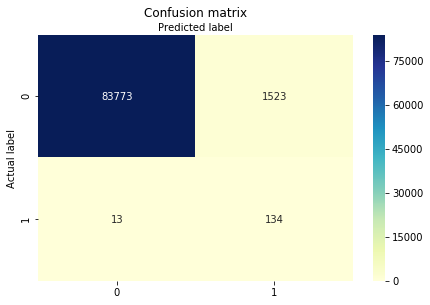

In [41]:
# Prediction on original dataset
y_pred_full_model2 = lr_under_C2.predict(X_test)
cross_validation_metrics(lr_under_C2,X_under_train,y_under_train)
print_accuracy_metrics(y_test,y_pred_full_model2)

### 5] Logistic regression with C=1

In [39]:
lr_under_C3 = LogisticRegression(C=1,penalty = 'l1')
lr_under_C3.fit(X_under_train,y_under_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Logistic Regression Cross Validation Score(Recall):  91.19%
Recall: 0.9259259259259259
Log Loss: 1.4306248896684717
Precision: 0.03190810465858328
Accurcay: 0.9585801233609739
AUC:  0.9422770694605426
F1 Score: 0.061690314620604564
Confusion matrix:
 [[70301  3034]
 [    8   100]]


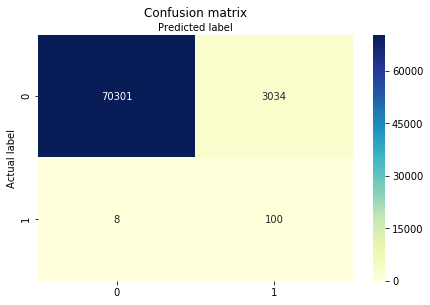

In [40]:
# Prediction on original dataset
y_pred_full_model3 = lr_under_C3.predict(X_test)
cross_validation_metrics(lr_under_C3,X_under_train,y_under_train)
print_accuracy_metrics(y_test,y_pred_full_model3)

### 6] Logistic regreesion with C=10

In [41]:
lr_under_C4 = LogisticRegression(C=10,penalty = 'l1')
lr_under_C4.fit(X_under_train,y_under_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Logistic Regression Cross Validation Score(Recall):  90.51%
Recall: 0.9259259259259259
Log Loss: 1.6827008224584545
Precision: 0.027247956403269755
Accurcay: 0.951281946543578
AUC:  0.9386226070619608
F1 Score: 0.05293806246691372
Confusion matrix:
 [[69765  3570]
 [    8   100]]


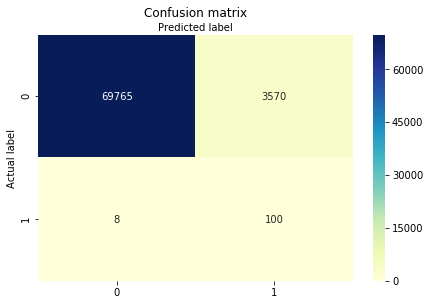

In [42]:
# Prediction on original dataset
y_pred_full_model4 = lr_under_C4.predict(X_test)
cross_validation_metrics(lr_under_C4,X_under_train,y_under_train)
print_accuracy_metrics(y_test,y_pred_full_model4)

### 7] Decision Tree Classifier

In [43]:
DecisionTreeClassifier= DecisionTreeClassifier()
DecisionTreeClassifier.fit(X_under_train,y_under_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Logistic Regression Cross Validation Score(Recall):  87.12%
Recall: 0.9722222222222222
Log Loss: 3.9090580892603124
Precision: 0.012479201331114808
Accurcay: 0.886823795324265
AUC:  0.9294601259062294
F1 Score: 0.02464210279277165
Confusion matrix:
 [[65026  8309]
 [    3   105]]


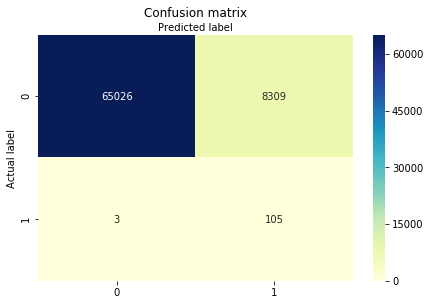

In [44]:
# Prediction on original dataset
y_pred_DecisionTree = DecisionTreeClassifier.predict(X_test)
cross_validation_metrics(DecisionTreeClassifier,X_under_train,y_under_train)
print_accuracy_metrics(y_test,y_pred_DecisionTree)

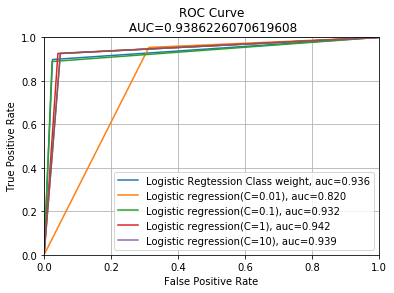

In [45]:
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y_test, y_balanced_pred)
auc = metrics.roc_auc_score(y_test, y_balanced_pred)
plt.plot(fpr,tpr,label="Logistic Regtession Class weight, auc="+ '{0:.3f}'.format(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_full_model1)
auc = metrics.roc_auc_score(y_test, y_pred_full_model1)
plt.plot(fpr,tpr,label="Logistic regression(C=0.01), auc="+ '{0:.3f}'.format(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_full_model2)
auc = metrics.roc_auc_score(y_test, y_pred_full_model2)
plt.plot(fpr,tpr,label="Logistic regression(C=0.1), auc="+'{0:.3f}'.format(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_full_model3)
auc = metrics.roc_auc_score(y_test, y_pred_full_model3)
plt.plot(fpr,tpr,label="Logistic regression(C=1), auc="+'{0:.3f}'.format(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_full_model4)
auc = metrics.roc_auc_score(y_test, y_pred_full_model4)
plt.plot(fpr,tpr,label="Logistic regression(C=10), auc="+'{0:.3f}'.format(auc))

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve\n AUC={auc}'.format(auc = auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend(loc="lower right")

Obviously, trying to increase recall, tends to come with a decrease of precision. However, in our case, if we predict that a transaction is fraudulent and turns out not to be, is not a massive problem compared to the opposite.

### Predictions on new samples

In [13]:
data_test=pd.read_csv('creditcard_test_dataset.csv')

In [14]:
data_test.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,30808,109847,1.930307,-0.234417,-1.583368,0.024786,1.016470,1.179664,-0.386242,0.327416,...,-0.437585,0.211402,1.015098,0.073241,-0.804496,0.072202,-0.383211,0.016787,-0.081815,1.00
1,174948,84730,-5.053316,-3.617236,-0.323455,1.447171,-0.097495,-0.154917,-2.076441,1.331307,...,-1.351008,-0.202483,0.036442,-1.901898,0.090641,-1.777126,0.947972,0.954071,-1.577919,333.48
2,203982,95957,0.090684,1.197902,-1.370219,0.770437,0.857203,-0.698486,1.350617,-0.952780,...,0.617074,-0.255027,0.378177,-0.126596,0.572250,0.347829,0.538705,-0.211582,-0.267241,50.14
3,283146,142109,1.808668,-1.197522,-2.291089,-0.690236,-0.312654,-1.756994,0.631548,-0.725965,...,0.457894,0.498576,0.927097,-0.283918,0.134011,0.372327,0.050185,-0.121994,-0.038088,254.04
4,47316,129034,-0.920372,1.003867,-0.110709,-2.771173,0.841827,-0.497278,0.769851,0.474075,...,-0.175248,-0.238352,-0.849203,-0.124786,0.086646,-0.007944,0.360582,0.090110,0.091000,1.00


In [15]:
data_test.tail()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
39995,33211,87180,-0.227015,1.066681,0.167350,0.847756,0.918577,-0.569415,1.412774,-0.317352,...,0.007818,0.115365,0.685676,-0.300523,-0.008611,-0.105765,-0.433028,0.129265,0.010438,13.99
39996,226678,66735,1.080631,0.072792,0.193645,1.189376,-0.379073,-0.941658,0.310233,-0.237765,...,0.009391,0.075056,0.056154,-0.170659,0.388427,0.646854,-0.336122,-0.004275,0.034426,89.16
39997,91144,69391,-0.366346,-0.123654,1.574127,-1.620753,-1.152640,-0.860367,-0.407476,-0.123524,...,-0.106231,-0.167896,-0.034830,-0.125103,0.357849,-0.137647,-0.134737,0.253740,0.180461,10.00
39998,151948,84607,1.245859,-0.208636,-0.083039,-0.792677,-0.621157,-1.219052,0.085329,-0.130222,...,-0.217895,0.033446,0.241614,-0.169362,0.550034,0.853734,-0.576327,0.022538,0.001399,7.71
39999,80174,70403,-0.633590,0.812096,2.561737,0.446063,-0.448034,-0.683693,0.267501,-0.008028,...,0.149068,0.007932,-0.015742,-0.131304,0.736886,-0.036651,0.325312,0.051134,0.087213,6.47


In [16]:
data_test['normal_amount'] = StandardScaler().fit_transform(data_test['Amount'].values.reshape(-1,1))
data_test1 = data_test.drop(['Amount','Time','id'], axis=1)

In [42]:
new_pred_class = lr_under_C2.predict(data_test1)

In [43]:
new_pred_class

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [44]:
new_pred_class_prob = lr_balanced.predict_proba(data_test1)[:, 1]

In [45]:
new_pred_class_prob

array([0.04646066, 0.00050197, 0.05586541, ..., 0.01563743, 0.03944736,
       0.06019283])

In [58]:
pd.DataFrame({'ID':data_test.id,'Class':new_pred_class}).set_index('ID').to_csv('submission_credit1.csv')

In [46]:
pd.DataFrame({'ID':data_test.id,'Class':new_pred_class_prob}).set_index('ID').to_csv('submission_credit_prob1.csv')